In [1]:
%cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_14_rasterization_3
!pwd

/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_14_rasterization_3
/bin/bash: /home/skyworker/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_14_rasterization_3


In [2]:
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image

In [5]:
from model import *
from dataset import *

# Load YAML.
cfg = OmegaConf.load('config.yaml')

# Get CFG
seed = cfg.training.seed
batch_size = cfg.training.batch_size
num_slots = cfg.attention.num_slots
num_iters = cfg.attention.num_iters
resolution = tuple(cfg.dataset.resolution)

# Set target frame.
frame = 5

# Load val dataset.
val_dir = '/home/skyworker/result/4DGS_SlotAttention/shape_of_motion/'
val_seq = 'movi_a_0010_anoMask'
test_set = ShapeOfMotion(os.path.join(val_dir,val_seq), cfg.dataset)

# Load model.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SlotAttentionAutoEncoder(cfg.dataset, cfg.cnn, cfg.attention).to(device)
model.load_state_dict(torch.load(os.path.join('checkpoints','100.ckpt' ))['model_state_dict'])

# Inference.
model = model.to(device)
sample = test_set[frame]
image = sample['gt_imgs'].to(device)
image = image.squeeze(0)
image = image.cpu().detach().numpy()

if cfg.attention.use_all_gs:
    selected = [k for k, m in zip(sample['all_gs'], sample['feature_mask']) if m]
    gs = torch.cat(selected, dim=-1)
else:
    gs = sample['fg_gs']
    # pos_embed = sample['fg_gs_pos']
    

Ks = sample['Ks']
w2cs = sample['w2cs']
gs = gs[None].to(device)
Ks = Ks[None].to(device)
w2cs = w2cs[None].to(device)
pos_embed = sample['all_gs'][0].to(device)

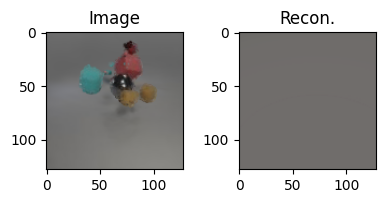

In [6]:
recon_combined = model(gs, pos_embed, Ks=Ks, w2cs=w2cs).to(torch.uint8)
# Squeeze.
recon_combined = recon_combined.squeeze(0)
# recons = recons.squeeze(0)
# masks = masks.squeeze(0)

# Convert to numpy.
recon_combined = recon_combined.cpu().detach().numpy()
# recons = recons.cpu().detach().numpy()
# masks = masks.cpu().detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
# plt.imshow(image, cmap='gray')
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
plt.tight_layout()

NameError: name 'masks' is not defined

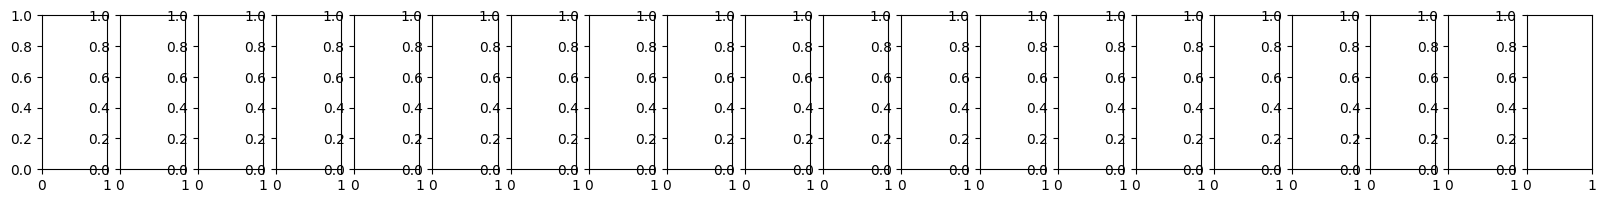

In [5]:
fig, ax = plt.subplots(1, num_slots, figsize=(20, 2))
for i in range(num_slots):
  picture = masks[i]
  # picture = recons[i] * masks[i] + (1 - masks[i])
  ax[i].imshow(picture, cmap="plasma")
  ax[i].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')
plt.tight_layout()

In [ ]:
!tensorboard --logdir=logs

/bin/bash: /home/skyworker/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
